In [1]:
from __future__ import print_function
import os
import random
import torch.nn as nn
import torch.utils.data
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# bSet random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
# Set the device to run on: GPU or CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [5]:

class Generator(nn.Module):
    def __init__(self, ngpu, nc, nz, ngf):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

In [6]:
# inference params
params = {
    'ngpu' : 0,
    'nc' : 1,
    'nz': 100,
    'ngf' : 64    
}

In [7]:
# Create the generator network.
netG = Generator(params['ngpu'],params['nc'], params['nz'], params['ngf']).to(device)

In [8]:
load_path = "models/dcgan_mnist_4.pt" # model path
save_dir = "images"
num_output = 4 # 

In [9]:
state_dict = torch.load(load_path)

In [10]:
# Load the trained generator weights.
netG.load_state_dict(state_dict['model_G_state_dict'])

<All keys matched successfully>

In [12]:
noise = torch.randn(int(num_output),params['nz'], 1, 1, device=device)

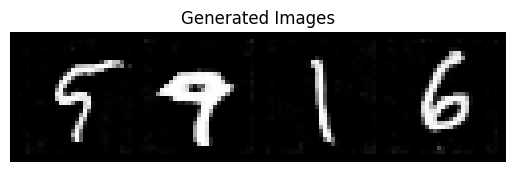

In [14]:
with torch.no_grad():
    generated_img = netG(noise).detach().cpu()
    os.makedirs(save_dir, exist_ok=True)
    vutils.save_image(generated_img, save_dir+"test.png", normalize=True)
 
plt.axis('off')
plt.title('Generated Images')
plt.imshow(np.transpose(vutils.make_grid(generated_img, padding=2, normalize = True), (1,2,0)))
plt.show()